In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 12 variables share a factor structure and the other 8 are noise

In [2]:
N = 5000
D_factor = 10
D_noise = 10
P = 3

V = np.abs(np.random.normal(1., 1., size=(P,D_factor)))
Z = np.abs(np.random.normal(0.1, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor*2))
X[:, ::2] = np.random.poisson(ZV)
X[:, 1::2] = np.random.poisson(2.,size=(N,D_factor))

In [3]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


In [5]:
losses = factor.calibrate_advi(
    num_epochs=200, learning_rate=.1)



W0519 21:35:05.984235 4458962368 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 57.48729373408252
Epoch 1: average-batch loss: 47.370640856731356 last batch loss: 39.07419173941262
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 38.566376105184005 last batch loss: 35.70333306489642
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 34.776677634679764 last batch loss: 34.13499595480425
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 33.69584818605782 last batch loss: 33.54259999264046
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 33.547588100124884 last batch loss: 33.395431234053575
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 33.540778515266005 last batch loss: 33.49338834123175
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 33.469822869096966 last batch loss: 33.32628282374261
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 33.39167536724135 last batch loss: 33.22664052669737
Saved a checkpoint: ./.tf

Epoch 69: average-batch loss: 30.11133782667006 last batch loss: 30.155674712369485
Saved a checkpoint: ./.tf_ckpts/chkpt-59
Epoch 70: average-batch loss: 30.075420409838216 last batch loss: 30.039374563881392
Saved a checkpoint: ./.tf_ckpts/chkpt-60
Epoch 71: average-batch loss: 30.05544717952812 last batch loss: 30.07094970947783
Saved a checkpoint: ./.tf_ckpts/chkpt-61
Epoch 72: average-batch loss: 30.09484047479257 last batch loss: 30.048365579214902
We are in a loss plateau learning rate: 0.0015625 loss: 29.833909089188506
Restoring from a checkpoint - loss: 29.88760834333707
Epoch 73: average-batch loss: 30.018555514766813 last batch loss: 30.01263736987927
Saved a checkpoint: ./.tf_ckpts/chkpt-62
Epoch 74: average-batch loss: 29.999923701301544 last batch loss: 29.97820725117814
Saved a checkpoint: ./.tf_ckpts/chkpt-63
Epoch 75: average-batch loss: 29.988472768024156 last batch loss: 29.97633730951674
Saved a checkpoint: ./.tf_ckpts/chkpt-64
Epoch 76: average-batch loss: 29.9568

Epoch 137: average-batch loss: 29.6732904411302 last batch loss: 29.691743770154623
Epoch 138: average-batch loss: 29.67561184177642 last batch loss: 29.68359972545718
We are in a loss plateau learning rate: 2.384185791015625e-08 loss: 29.481888504004342
Restoring from a checkpoint - loss: 29.48160797489372
Epoch 139: average-batch loss: 29.670323550493197 last batch loss: 29.669887380994233
Epoch 140: average-batch loss: 29.67021354632238 last batch loss: 29.677555703679708
Epoch 141: average-batch loss: 29.6696148250254 last batch loss: 29.668379899713443
Epoch 142: average-batch loss: 29.677279482133276 last batch loss: 29.7071108070369
Epoch 143: average-batch loss: 29.66459796991564 last batch loss: 29.66225852378182
Saved a checkpoint: ./.tf_ckpts/chkpt-96
Epoch 144: average-batch loss: 29.68042517029416 last batch loss: 29.706422741462863
We are in a loss plateau learning rate: 5.960464477539063e-09 loss: 29.483352265045355
Restoring from a checkpoint - loss: 29.462190883385876


In [6]:
waic = factor.waic()
print(waic)

{'waic': 273189.50748133566, 'se': 1826.3645295681051, 'lppd': -32549.306568828477, 'pwaic': 104045.44717183935}


In [7]:
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": tf.squeeze(
            factor.surrogate_distribution.sample(1000)['w']*factor.norm_factor).numpy().T})

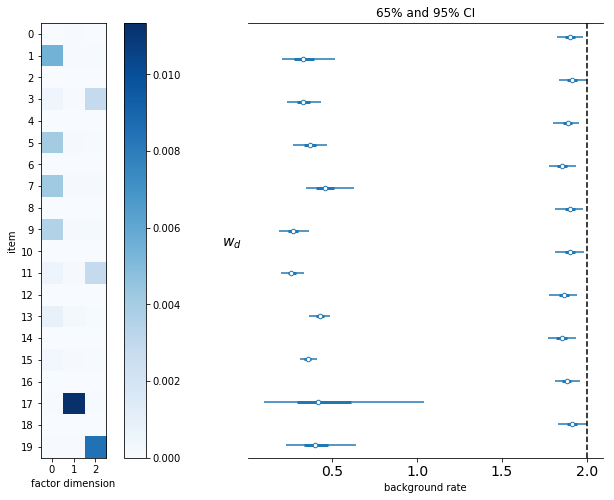

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(2.0, linestyle='dashed', color="black")
plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()
